In [3]:
%load_ext autoreload
%autoreload 2

# Flash responses

This notebook introduces flash responses and the flash response index (FRI), a measure of flash response tuning, demonstrates how to compute them with our code.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [ ]:
#@markdown **Check access to GPU**
import torch
try:
  cuda_name = torch.cuda.get_device_name()
  print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
except RuntimeError:
  import warnings
  warnings.warn("You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow).")

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [ ]:
#@markdown **Install Flyvis**
%%capture
!git clone https://github.com/flyvis/flyvis-dev.git
%cd /content/flyvis-dev
!pip install -e .

## Flash stimuli

To elicit flash responses, experimenters show a flashing dot to the subject in the center of their field of view. We generate and render these stimuli with the `Flashes` dataset.

In [33]:
# import dataset and visualization helper
import torch
from flyvision.datasets.flashes import Flashes
from flyvision.animations.hexscatter import HexScatter

In [34]:
# initialize dataset
dataset = Flashes(
    dynamic_range=[0, 1], # min and max pixel intensity values, must be in range [0, 1]
    t_stim=1.0, # duration of flash
    t_pre=1.0, # duration of period between flashes
    dt=1/200, # temporal resolution of rendered video
    radius=[-1, 6], # radius of flashing dot. -1 fills entire field of view
    alternations=(0, 1, 0), # flashing pattern, off - on - off
)

In [35]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

,baseline,intensity,radius
0,0.5,0,-1
1,0.5,0,6
2,0.5,1,-1
3,0.5,1,6


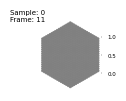

In [36]:
# visualize single sample
%matplotlib inline
animation = HexScatter(dataset[3][None, ::50, None], vmin=0, vmax=1) # intensity=1, radius=6
animation.animate_in_notebook()

## Network flash response

Now that we have generated the stimulus, we can use it to drive a trained connectome-constrained network.

In [37]:
from flyvision import results_dir
from flyvision.network import NetworkView
# model are already sorted by task error
# we take the best performing model, model 0000
best_model_dir = results_dir / "opticflow/000/0000"
best_model_view = NetworkView(best_model_dir)

In [38]:
# rebuild network from checkpoint
network = best_model_view.init_network(chkpt="best_chkpt")

In [39]:
# check out function for running network simulation
network.simulate??

In [40]:
# compute network responses to all flash stimuli
responses = network.simulate(torch.stack(dataset[:]).unsqueeze(2), dt=dataset.dt)

### FlashResponseView
We've now computed network flash responses for all cells in the network. Flash response operations are handled by the `FlashResponseView` class.

In [60]:
from flyvision.utils.nodes_edges_utils import CellTypeArray
from flyvision.analysis.flash_responses import FlashResponseView
# extract cell responses in central column
central_responses = responses[:, :, network.connectome.central_cells_index[:]]
# wrap responses for easy access by cell type
responses = CellTypeArray(
    central_responses,
    cell_types=network.connectome.unique_cell_types[:].astype(str),
)

In [61]:
# initialize FlashResponseView
frv = FlashResponseView(arg_df=dataset.arg_df, config=dataset.config, responses=responses)

### Response traces

We can plot single-cell response traces with `FlashResponseView.plot_traces()`. Here, we plot responses of L1 cells to flashes with radius 6.

In [62]:
%matplotlib inline
fig, *_ = frv.plot_traces("L1", radius=6)
fig.show()

AssertionError: 

### Flash response index

The flash response index is a measure of the strength of contrast tuning of a particular cell. It is computed as the difference between the cell's peak voltage in response to on-flashes (intensity = 1) and off-flashes (intensity = 0), divided by the sum of those peak values.

That is, given a single neuron's response to on-flashes `r_on` and off-flashes `r_off` (both of `shape=(T,)`), we can compute the flash response index with

```
r_on_max = max(r_on)
r_off_max = max(r_off)
fri = (r_on_max - r_off_max) / (r_on_max + r_off_max + 1e-16)
```

with the additional `1e-16` simply for numerical stability. Before this calculation, the response traces are shifted to be non-negative.

The flash response index can take on values between $-1$, when the off response is much stronger (or more positive) than the on response, to $1$, when the on response is much stronger (or more positive) than the off response.

For the L1 cell plotted before, we can see that it displays a positive response to off flashes and a negative response to on flashes, so we expect a negative flash response index.

In [85]:
# get FRI for L1 cell
fri = frv.cell_type("L1").fri(radius=6).responses.value()
print(fri)